In [1]:
import pyJvsip as pjv
import matplotlib.pyplot as plt

In [2]:
def scan_achar(fptr):
   l=str()
   while not l.startswith('*'):
        l=fptr.readline()
   return l

def param_read( param_file_name):
     fptr = open(param_file_name,"r");
     obj={'c':1,'Fs':2,'Nts':3,'Dsens':4,'Nsens':5,'Navg':6,
           'Nsim_freqs':'7','sim_freqs':[],'sim_bearings':[],'Nsim_noise':10}
     # get the propagation speed
     l=scan_achar(fptr)
     obj['c']=float(l.partition('*')[2].partition(' ')[0])
     # get the sample rate
     l=scan_achar(fptr)
     obj['Fs']=float(l.partition('*')[2].partition(' ')[0])
     # get the time series length */
     l=scan_achar(fptr)
     obj['Nts']=int(l.partition('*')[2].partition(' ')[0])
     # get the sensor spacing */
     l=scan_achar(fptr)
     obj['Dsens']=float(l.partition('*')[2].partition(' ')[0])
     # get the number of sensors */
     l=scan_achar(fptr)
     obj['Nsens']=int(l.partition('*')[2].partition(' ')[0])
     # get the number of averages */
     l=scan_achar(fptr)
     obj['Navg']=int(l.partition('*')[2].partition(' ')[0])
     # get the number of narrow band simualted tones */
     l=scan_achar(fptr)
     obj['Nsim_freqs']=int(l.partition('*')[2].partition(' ')[0])
     n=obj['Nsim_freqs']
     sim_freqs = []
     for i in range(n):
         l=scan_achar(fptr)
         sim_freqs += [float(l.partition('*')[2].partition(' ')[0])]
     obj['sim_freqs']=sim_freqs
     sim_bearings = []
     for i in range(n):
         l=scan_achar(fptr)
         sim_bearings += [float(l.partition('*')[2].partition(' ')[0])]
     obj['sim_bearings']=sim_bearings
     # Nsim_noise
     l=scan_achar(fptr)
     obj['Nsim_noise']=int(l.partition('*')[2].partition(' ')[0])
     fptr.close()
     return obj
class Sim_ts(object):
    """ Simulate acoustic data with narrow band point sources from multiple
        directions and isotropic, band-limited noise.
    """
    def __init__(self,param):
        c=param['c']
        Dsens = param['Dsens']
        Nsens = param['Nsens']
        Nts = param['Nts']
        Fs = param['Fs']
        row=pjv.VSIP_ROW
        mem=pjv.VSIP_MEM_NONE
        state=pjv.VSIP_STATE_SAVE
        sym=pjv.VSIP_NONSYM
        rng=pjv.VSIP_PRNG
        L = int(2 * Fs/(Nsens * Dsens/c) + Nts + 1)
        self.Nsim_freqs = param['Nsim_freqs']
        self.Nsens = Nsens
        self.Nsim_noise=param['Nsim_noise']
        self.Nts = Nts
        self.Fs = Fs
        kernel     = pjv.create('kaiser_d',6,1)
        self.fir   = pjv.FIR('fir_d',kernel, sym, 2*L, 2, state, 0,0)
        self.noise = pjv.create('vview_d',2*L)
        self.bl_noise = pjv.create('vview_d',L)
        self.rand  = pjv.Rand('PRNG',7)
        self.t = pjv.create('vview_d',Nts)
        self.t.ramp(0.0, 1.0/Fs)
        self.t_dt = pjv.create('vview_d',Nts)    
        self.m_data = pjv.create('mview_d',Nsens,Nts)
        self.v_data = self.m_data.rowview(0)
        self.d_t = param['Dsens']/param['c'] #travel time at end-fire between sensors
        self.sim_freqs = param['sim_freqs']
        self.sim_bearings = param['sim_bearings']
    @property
    def nb_sim(self):
        from numpy import pi,cos
        for i in range(self.Nsim_freqs):
            f=self.sim_freqs[i]
            b=self.d_t * cos(self.sim_bearings[i] * pi/180.0)
            for j in range(self.Nsens):
                dt = float(j) * b
                pjv.add(dt,self.t,self.t_dt)
                pjv.mul(2 * pi * f, self.t_dt, self.t_dt)
                pjv.cos(self.t_dt,self.t_dt)
                pjv.mul(3.0,self.t_dt,self.t_dt)
                v_data = self.m_data.rowview(j)
                pjv.add(self.t_dt,v_data,v_data)
    @property
    def noise_sim(self):
        from numpy import pi, cos
        d_t=self.d_t * self.Fs #sensor-to-sensor travel time at end-fire in samples
        o_0    = d_t * self.Nsens + 1 # array travel time at end-fire in samples
        a_stp = pi/self.Nsim_noise # angle step
        bl_attr = self.bl_noise.attrib
        for j in range(self.Nsim_noise):
            a_crct = cos(float(j) * a_stp)
            self.rand.randn(self.noise)
            self.fir.flt(self.noise,self.bl_noise)
            pjv.mul(12.0/float(self.Nsim_noise),self.bl_noise,self.bl_noise)
            self.bl_noise.putlength(self.Nts)
            for i in range(self.Nsens):
               index = int(o_0 + i * d_t * a_crct)
               self.bl_noise.putoffset(index)
               v_data=self.m_data.rowview(i)
               pjv.add(self.bl_noise,v_data,v_data)
            self.bl_noise.putattrib(bl_attr)
        pjv.add(-self.m_data.meanval,self.m_data,self.m_data);
        print(self.m_data[5,4])
    @property
    def zero(self):
        self.m_data.fill(0.0)
    @property
    def instance(self):
        return self.m_data
class Kw(object):
    def __init__(self,param):
        fftfwd=pjv.VSIP_FFT_FWD
        Nsens=param['Nsens']
        Nts=param['Nts']
        Nfreq=int(Nts/2) + 1
        self.Navg=param['Navg']
        self.Nfreq=Nfreq
        self.cm_freq=pjv.create('cmview_d',Nsens,Nfreq,'COL') 
        self.rm_freq=self.cm_freq.realview
        self.m_gram=pjv.create('mview_d',Nsens,Nfreq,'COL')
        self.rcfftm=pjv.FFT('rcfftmop_d',Nsens,Nts,1,pjv.VSIP_ROW,0,0)
        self.ccfftm=pjv.FFT('ccfftmip_d',Nsens,Nfreq,fftfwd,1,pjv.VSIP_COL,0,0)
        self.ts_taper=pjv.create('vview_d',Nts).hanning
        self.array_taper=pjv.create('vview_d',Nsens).hanning
    @property
    def zero(self):
        self.m_gram.fill(0.0)
    def kw(self,m_data):
        pjv.vmmul(self.ts_taper.ROW,m_data,m_data);
        pjv.vmmul(self.array_taper.COL,m_data,m_data);
        self.rcfftm.dft(m_data,self.cm_freq)
        self.ccfftm.dft(self.cm_freq)
        pjv.cmagsq(self.cm_freq,self.rm_freq) #check rm_freq real part?
        pjv.mul(1.0/self.Navg,self.rm_freq, self.rm_freq)
        pjv.add(self.rm_freq,self.m_gram,self.m_gram)
    @property
    def instance(self):
        return self.m_gram

In [3]:
import numpy as np
def mToA(m):
    M=m.collength
    N=m.rowlength
    a=np.empty((M,N),float,'C')
    for i in range(M):
        for j in range(N):
            a[i,j] = m[i,j]
    return a

In [4]:
def beamformer():
    param = param_read("param_file")
    ts = Sim_ts(param)
    kw = Kw(param)
    navg=param['Navg']
    kw.zero
    dtaIn=ts.instance
    gramOut=kw.instance
    for i in range(navg):
        print((i, "of", navg))
        ts.zero
        ts.nb_sim
        ts.noise_sim
        kw.kw(dtaIn)
    for i in range(gramOut.rowlength):
        v=gramOut.colview(i)
        v.freqswap
    max = gramOut.maxval
    avg = gramOut.meanval
    print('avg',avg)
    pjv.clip(gramOut,0.0,max,avg/100000.0,max,gramOut)
    pjv.log10(gramOut,gramOut)
    min = gramOut.minval
    pjv.add(-min,gramOut,gramOut)
    max = gramOut.maxval
    pjv.mul(1.0/max,gramOut,gramOut)
    fig = plt.figure(1,figsize=(10,4))
    ax = fig.add_axes([0.10,0.10,0.85,0.80])
    ax.set_yticklabels(['0','0','30','60','90','120','150','180'])
    ax.yaxis.set_ticks_position('right')
    im=mToA(gramOut)
    plt.imshow(im)
    plt.title('K-Omega Beamformer Output')
    plt.xlabel('Frequency')
    plt.ylabel(r'$\frac{cos(\theta)}{\lambda}$',fontsize=16,rotation='horizontal')
    plt.colorbar()

In [5]:
beamformer()

(0, 'of', 8)
4.441018625291905
(1, 'of', 8)
10.510626611794182
(2, 'of', 8)
-0.15119091443097332
(3, 'of', 8)
1.7657494679042594
(4, 'of', 8)
-1.5512058848938475
(5, 'of', 8)
-1.1120270129086287
(6, 'of', 8)
3.528614334232501
(7, 'of', 8)
-1.639620518856672
avg 703131.8031643464


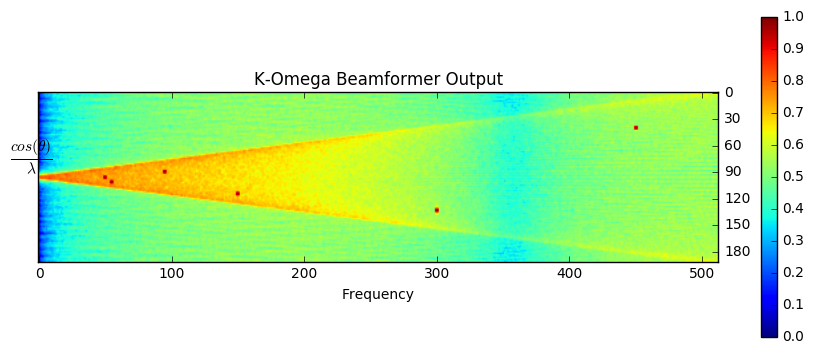

In [6]:
plt.show()